# TrES-3b transmission spectroscopy: GP hyperparameter optimisation

*<a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a>, University of Oxford*

This notebook is a part in a series of notebooks working as an appendix to Parviainen et al. (2015, submitted), aiming to make the analysis presented in the paper easily reproductable. The results and the figures presented in the paper can be reproduced by following these notebooks in the numbered order.

*Dependencies:* See `000_README.ipynb` for the list of required Python packages, and how to install them.

Here we optimise the GP hyperparameters to the residuals from the white-noise narrow-band modelling. This is done both for the masked and unmasked light curves. We assume that the red noise properties are constant over the spectrum, but the white noise level changes from passband to passband. Thus, we first optimise the three hyperparameters for each passband, then take the median values of the (inverse) GP input and ouput scales, fix them, and refit the white noise level for each passband keeping the two other hyperparameters fixed.

*Note:* We also did a small test run to see how much marginalising over the hyperparameters would affect the parameter estimates, the effect was not significant.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import fmin

from george import GP, HODLRSolver, BasicSolver
from george.kernels import ExpKernel
from lpf_nw import LPFunction as LPF

from core import *

In [3]:
ddir   = 'results'
dfiles = ['TrES_3b_color_nomask_wn_mc.npz',
          'TrES_3b_color_masked_wn_mc.npz']

In [4]:
chains = [load(join(ddir,f))['chains'] for f in dfiles]
mpvs   = [median(ch.reshape([-1,ch.shape[-1]]), 0) for ch in chains]

In [10]:
df_aux = pd.read_hdf('results/light_curves.h5', 'aux')
df_lcr = pd.read_hdf('results/light_curves.h5', 'final/nb_nomask')
df_lcm = pd.read_hdf('results/light_curves.h5', 'final/nb_masked')
mask    = array(df_aux.bad_mask, dtype=np.bool)

time = array(df_aux.mjd-56846+0.5)[mask]
airmass = array(df_aux.airmass)[mask]
fluxes = [array(df_lc)[mask,:] for df_lc in [df_lcr, df_lcm]]

lpf = LPF(time, fluxes[0], airmass, nthreads=4)

In [11]:
fluxes_m  = [lpf.compute_lc_model(mpv) for mpv in mpvs]
residuals = [fo-fm for fo,fm in zip(fluxes, fluxes_m)] 

In [12]:
class GPFitter(object):
    def __init__(self, time, residuals, solver=HODLRSolver):
        self.time = time.copy()
        self.residuals = residuals.copy()
        self.gp = GP(ExpKernel, solver=solver)
        
    def compute_gp(self, pv):
        self.gp.kernel = pv[2]**2*ExpKernel(1./pv[0])
        self.gp.compute(self.time, pv[1])
        
    def predict(self, pv, ipb=0):
        self.compute_gp(pv)
        return self.gp.predict(self.residuals[:,ipb], self.time, mean_only=True)
    
    def __call__(self, pv, ipb=0):
        if any(pv<0):
            return inf
        self.compute_gp(pv)
        return -self.gp.lnlikelihood(self.residuals[:,ipb])
    
    
class GPFitterWN(GPFitter):
    def __init__(self, time, residuals, inv_scale, output_scale, solver=HODLRSolver):
        super(GPFitterWN, self).__init__(time, residuals, solver)
        self.gp.kernel = output_scale**2*ExpKernel(1./inv_scale)    
        
    def compute_gp(self, pv):
        self.gp.compute(self.time, pv[0])

In [13]:
gpfs = [GPFitter(time, res, HODLRSolver) for res in residuals]

In [14]:
pvs = [array([fmin(gpf, [1e4, 0.0005, 0.0005], args=(ipb,), maxfun=4000, maxiter=4000, disp=False) 
             for ipb in range(16)]) for gpf in gpfs]

In [16]:
mps = [median(pv,0) for pv in pvs]

In [17]:
gpfw = [GPFitterWN(time, res, mp[0], mp[2]) for res,mp in zip(residuals,mps)]

In [18]:
pvw = [array([fmin(gpf, [0.0005], args=(ipb,), maxfun=4000, maxiter=4000, disp=False) 
              for ipb in range(16)]) for gpf in gpfw]

In [20]:
pvbs = [pv.copy() for pv in pvs]

In [21]:
for i in range(2):
    pvbs[i][:,0] = mps[i][0]
    pvbs[i][:,1] = pvw[i][:,0]
    pvbs[i][:,2] = mps[i][2]

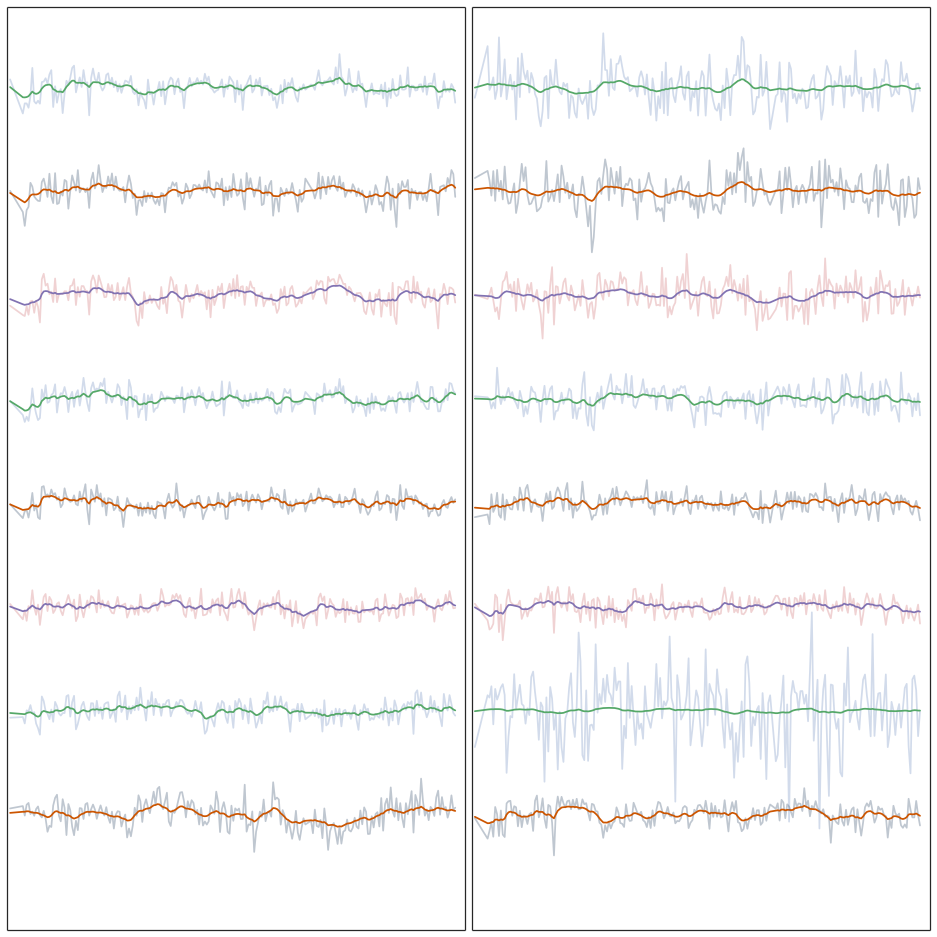

In [24]:
fig,axs = subplots(1,2, figsize=(13,13), sharey=True)
for i in range(2):
    for j in range(8):
        ipb = i*8+j
        axs[i].plot(time, j*0.009+gpfs[0].residuals[:,ipb], alpha=0.25)
        axs[i].plot(time, j*0.009+gpfs[0].predict(pvbs[0][ipb], ipb))
setp(axs, xticks=[], yticks=[])
fig.tight_layout()

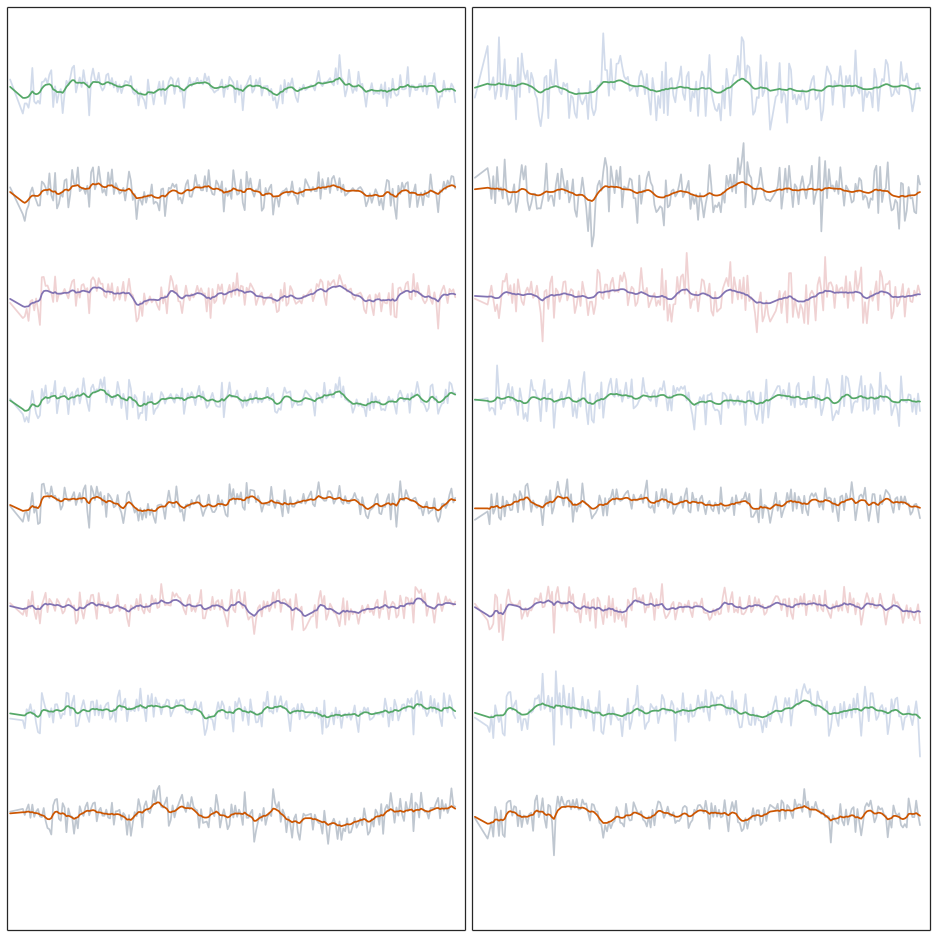

In [23]:
fig,axs = subplots(1,2, figsize=(13,13), sharey=True)
for i in range(2):
    for j in range(8):
        ipb = i*8+j
        axs[i].plot(time, j*0.009+gpfs[1].residuals[:,ipb], alpha=0.25)
        axs[i].plot(time, j*0.009+gpfs[1].predict(pvbs[1][ipb], ipb))
setp(axs, xticks=[], yticks=[])
fig.tight_layout()

## Save the fitted hyperparameters

In [28]:
df_nomask = pd.DataFrame(pvbs[0], columns='inv_scale wnoise rnoise'.split())
df_masked = pd.DataFrame(pvbs[1], columns='inv_scale wnoise rnoise'.split())

In [31]:
hdf = pd.HDFStore('results/light_curves.h5')
hdf.put('gp_hyperparameters/nomask', df_nomask, format='table', data_columns=True)
hdf.put('gp_hyperparameters/masked', df_masked, format='table', data_columns=True)
hdf.close()

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>